In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [538]:
# read in data
claims = pd.read_csv('../CoverMyMeds_data/dim_claims.csv')

In [539]:
claims.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved
0,1,417380,A,75.0,0
1,2,999001,A,NaN,1
2,3,417740,A,76.0,0
3,4,999001,A,NaN,1
4,5,417740,A,NaN,1


In [4]:
claims.dtypes

dim_claim_id                 int64
bin                          int64
drug                        object
reject_code                float64
pharmacy_claim_approved      int64
dtype: object

In [5]:
# replace nan with -99
claims['reject_code'].replace(np.nan, -99, inplace=True)

In [6]:
claims.bin.unique()

array([417380, 999001, 417740, 417614])

In [540]:
# Add new column payer
# convert bin from int to str
claims['payer'] = ''

In [541]:
# rename payers

claims.loc[claims.bin==417380, 'payer'] = 'C1'
claims.loc[claims.bin==999001, 'payer'] = 'C2'
claims.loc[claims.bin==417740, 'payer'] = 'C3'
claims.loc[claims.bin==417614, 'payer'] = 'C4'

In [542]:
claims.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,payer
0,1,417380,A,75.0,0,C1
1,2,999001,A,NaN,1,C2
2,3,417740,A,76.0,0,C3
3,4,999001,A,NaN,1,C2
4,5,417740,A,NaN,1,C3


In [543]:
# Add new column reject_reason
# convert reject_code from float to str

claims['reject_reason'] = 'approved'

In [544]:
claims.loc[claims.reject_code==70, 'reject_reason'] = 'Not_in_formulary'
claims.loc[claims.reject_code==75, 'reject_reason'] = 'In_formulary_needs_PA'
claims.loc[claims.reject_code==76, 'reject_reason'] = 'In_formulary_exceeded_limit'

In [564]:
# create new feature

claims['drug_payer'] = claims['drug'].astype(str)+'_'+claims['payer'].astype(str)

In [565]:
claims.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,payer,reject_reason,drug_payer
0,1,417380,A,75.0,0,C1,In_formulary_needs_PA,A_C1
1,2,999001,A,NaN,1,C2,approved,A_C2
2,3,417740,A,76.0,0,C3,In_formulary_exceeded_limit,A_C3
3,4,999001,A,NaN,1,C2,approved,A_C2
4,5,417740,A,NaN,1,C3,approved,A_C3


In [566]:
# Keep columns
keep_columns = ['drug_payer']


# X and y
X = claims[keep_columns]
y = claims['pharmacy_claim_approved']

In [25]:
len(y[y==1])

779625

In [24]:
len(y[y==0])

555951

In [567]:
X_oneHotEncode = pd.get_dummies(X, drop_first=True)

In [568]:
X_oneHotEncode.head()

,drug_payer_A_C2,drug_payer_A_C3,drug_payer_A_C4,drug_payer_B_C1,drug_payer_B_C2,drug_payer_B_C3,drug_payer_B_C4,drug_payer_C_C1,drug_payer_C_C2,drug_payer_C_C3,drug_payer_C_C4
0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0


In [569]:
# train_test_split
from sklearn.model_selection import train_test_split

In [570]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_oneHotEncode, y, test_size=0.25, random_state=42, stratify = y)

In [551]:
len(X_train)

1001682

In [95]:
len(X_test)

333894

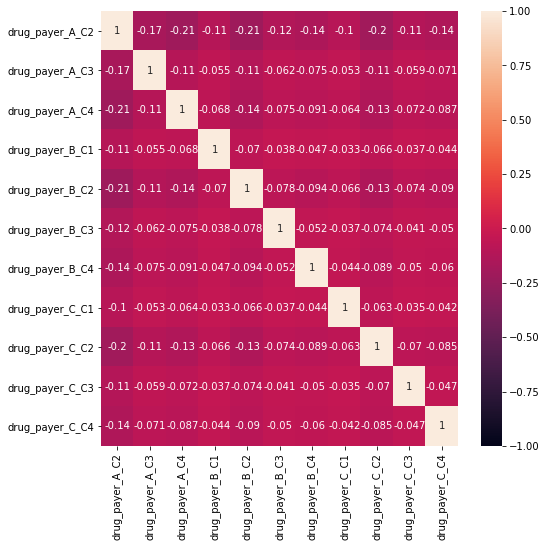

In [571]:
# correlation between independent features
plt.figure(figsize=(8,8))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)

# Logistic Regression

In [572]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [599]:
# calculate class weights
# Wj = n_samples / (n_classes * n_samples_j)

W_0 = len(y)/(2*len(y[y==0]))
W_1 = len(y)/(2*len(y[y==1]))

print(W_0)
print (W_1)

1.2011634118834214
0.8565502645502645


In [601]:
# Logistic regression object
clf = LogisticRegression(random_state = 42, solver= 'lbfgs', class_weight={0:W_0, 1:W_1})

In [602]:
# cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# evaluate model
scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

# report performance
print('ROC_AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

ROC_AUC: 0.922 (0.001)


In [596]:
X_train.columns

Index(['drug_payer_A_C2', 'drug_payer_A_C3', 'drug_payer_A_C4',
       'drug_payer_B_C1', 'drug_payer_B_C2', 'drug_payer_B_C3',
       'drug_payer_B_C4', 'drug_payer_C_C1', 'drug_payer_C_C2',
       'drug_payer_C_C3', 'drug_payer_C_C4'],
      dtype='object')

In [603]:
# fit model
clf.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1.2011634118834214, 1: 0.8565502645502645},
                   random_state=42)

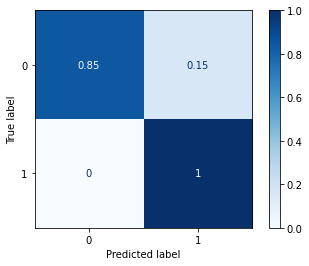

In [604]:
# confusion matrix
plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues, normalize='true')
plt.show()  

In [605]:
clf.coef_

array([[ 9.37810277,  9.37898835, -3.18657821,  9.39774219,  9.37408119,
        -2.41730655, -2.66038707, -2.20043896,  9.36044616, -2.35538103,
         9.39119011]])

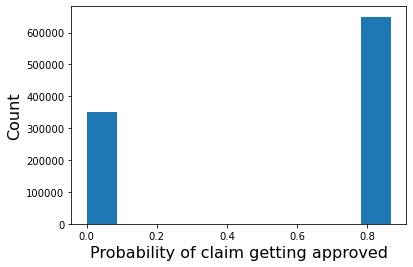

In [606]:
proba = clf.predict_proba(X_train)[:,1]
plt.hist(proba)
plt.xlabel('Probability of claim getting approved', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

<AxesSubplot:>

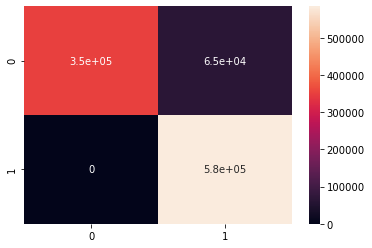

In [580]:
thresh = 0.5
y_test_pred = np.where(proba>thresh, 1, 0)
cm = confusion_matrix(y_train,y_test_pred)
sns.heatmap(cm, annot=True)

In [ ]:
claims.loc[claims.bin==417380, 'payer'] = 'C1'
claims.loc[claims.bin==999001, 'payer'] = 'C2'
claims.loc[claims.bin==417740, 'payer'] = 'C3'
claims.loc[claims.bin==417614, 'payer'] = 'C4'

In [581]:
def WillClaimGetApproved(Drug, Payer):

    X = np.array(['A_999001','A_417740','A_417614','B_417380','B_999001','B_417740','B_417614','C_417380','C_999001','C_417740','C_417614'])
    X1 = np.where(X==Drug+'_'+Payer, 1, 0)

    pred_prob = clf.predict_proba(X1.reshape(1,-1))
    
    thresh = 0.5
    if pred_prob[0][1] < 0.5 :
        reject_reason = claims[(claims['drug']==Drug) & (claims['bin']==int(Payer)) & (claims['pharmacy_claim_approved']==0)]['reject_reason']
        print (f'Your claim has {round((1-pred_prob[0][1]),2)*100} % chance to be rejected. You will need a PA. Reason for rejection : {np.array(reject_reason)[0]}')
    
    else:
        print (f'Your claim has {round(pred_prob[0][1],2)*100} % chance of approval. You don\'t need a PA.')
    
    return None
        
    
    
    

In [607]:
# What the app should do

WillClaimGetApproved('A','417614')

Your claim has 100.0 % chance to be rejected. You will need a PA. Reason for rejection : Not_in_formulary


# statsmodel

In [585]:
import statsmodels.api as sm

In [586]:
model = sm.Logit(endog=y_train, exog=X_train).fit()

         Current function value: 0.256549
         Iterations: 35


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [587]:
print(model.summary())

                              Logit Regression Results                             
Dep. Variable:     pharmacy_claim_approved   No. Observations:              1001682
Model:                               Logit   Df Residuals:                  1001671
Method:                                MLE   Df Model:                           10
Date:                     Thu, 20 May 2021   Pseudo R-squ.:                  0.6222
Time:                             12:37:03   Log-Likelihood:            -2.5698e+05
converged:                           False   LL-Null:                   -6.8020e+05
Covariance Type:                 nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
drug_payer_A_C2     2.2002      0.007    325.745      0.000       2.187       2.213
drug_payer_A_C3     2.2019      0.012    188.223      0.000       2.179     